In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
import pickle
import joblib
from joblib import Parallel, delayed
import tensorflow
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

2023-07-13 15:48:24.191679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Get the Dataset
df=pd.read_csv('table_yhoo.csv',na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)
df.head()

,Open,High,Low,Close,AdjClose,Volume
Date,,,,,,
1998-01-02,0,4.32812,4.34375,4.06250,4.14437,17153600
1998-01-05,0,4.02375,4.08625,3.91438,3.92563,25585600
1998-01-06,0,3.85938,4.07062,3.82812,3.99250,27243200
1998-01-07,0,3.92188,4.05500,3.91438,3.98813,15307200
1998-01-08,0,4.00000,4.12313,3.92188,4.01562,21256000


In [3]:
#Print the shape of Dataframe  and Check for Null Values
print("Dataframe Shape: ", df.shape)
print("Null Value Present:", df.isnull().values.any())

Dataframe Shape:  (3926, 6)
Null Value Present: False


In [4]:
#Set Target Variable
output_var = pd.DataFrame(df['AdjClose'])
#Selecting the Features
features = ['High', 'Low', 'Close', 'Volume']

In [5]:
#Scaling to decrease the computational cost of the data
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,High,Low,Close,Volume
Date,,,,
1998-01-02,0.006250,0.004572,0.004294,0.043503
1998-01-05,0.003544,0.002449,0.002913,0.068790
1998-01-06,0.002083,0.002320,0.002109,0.073761
1998-01-07,0.002639,0.002191,0.002913,0.037966
1998-01-08,0.003333,0.002753,0.002983,0.055806


In [6]:
feature_transform.shape

(3926, 4)

In [7]:
#Splitting to 90% Training set and 10% Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        x_train, x_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [8]:
x_train.shape

(3570, 4)

In [9]:
#Process the data for LSTM
trainX =np.array(x_train)
testX =np.array(x_test)
x_train = trainX.reshape(x_train.shape[0], 1, x_train.shape[1])
x_test = testX.reshape(x_test.shape[0], 1, x_test.shape[1])

In [10]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

2023-07-13 15:48:36.345898: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [11]:
#Model Training
history = lstm.fit(x_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
447/447 [==============================] - 3s 2ms/step - loss: 812.7745
Epoch 2/100
447/447 [==============================] - 1s 2ms/step - loss: 486.9076
Epoch 3/100
447/447 [==============================] - 1s 2ms/step - loss: 178.6140
Epoch 4/100
447/447 [==============================] - 1s 2ms/step - loss: 92.4594
Epoch 5/100
447/447 [==============================] - 1s 3ms/step - loss: 67.2633
Epoch 6/100
447/447 [==============================] - 1s 2ms/step - loss: 49.4395
Epoch 7/100
447/447 [==============================] - 1s 3ms/step - loss: 33.8420
Epoch 8/100
447/447 [==============================] - 1s 2ms/step - loss: 20.7158
Epoch 9/100
447/447 [==============================] - 1s 2ms/step - loss: 11.0147
Epoch 10/100
447/447 [==============================] - 1s 2ms/step - loss: 5.1470
Epoch 11/100
447/447 [==============================] - 1s 2ms/step - loss: 2.3891
Epoch 12/100
447/447 [==============================] - 1s 2ms/step - loss: 1.4235
E

447/447 [==============================] - 1s 2ms/step - loss: 0.5345
Epoch 100/100
447/447 [==============================] - 1s 2ms/step - loss: 0.5338


In [15]:
#LSTM Prediction

y_pred=lstm.predict(x_test)

12/12 [==============================] - 0s 2ms/step


In [22]:
# Save the model as a pickle in a file
joblib.dump(lstm, 'trained_model.pkl')
  
# Load the model from the file
lstm_from_joblib = joblib.load('trained_model.pkl')

INFO:tensorflow:Assets written to: ram://f9da314e-d7cc-4172-a73a-26c611152f69/assets


#LSTM Prediction
#y_pred= lstm.predict(x_test) 

#Use the loaded model to make predictions
y_pred = lstm_from_joblib.predict(x_test)

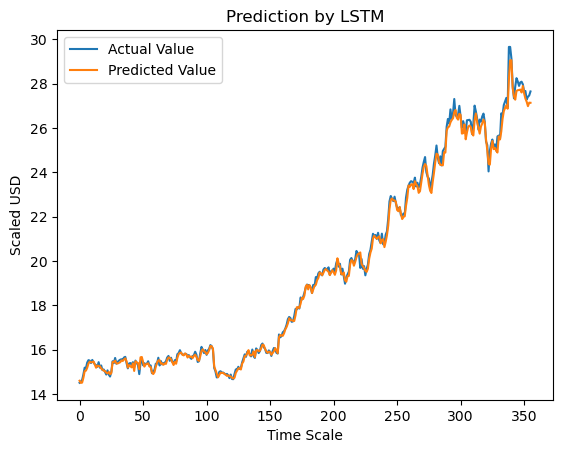

In [17]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='Actual Value')
plt.plot(y_pred, label='Predicted Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

In [19]:
# check results


cutoff = 0.6                              # decide on a cutoff limit
y_pred_classes = np.zeros_like(y_pred)    # initialise a matrix full with zeros
y_pred_classes[y_pred > cutoff] = 1       # add a 1 if the cutoff was breached

y_test_classes = np.zeros_like(y_pred)
y_test_classes[y_test > cutoff] = 1

print(confusion_matrix(y_test_classes, y_pred_classes))
print(classification_report(y_test_classes, y_pred_classes)) 

# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred)) 

[[356]]
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       356

    accuracy                           1.00       356
   macro avg       1.00      1.00      1.00       356
weighted avg       1.00      1.00      1.00       356



In [21]:
np.savetxt('test.csv',y_test,delimiter=',')
#y_test.to_csv("some_file.csv")